# Transformer for MNIST1D

## Configuration

Imports

In [1]:
import os
import requests
import pickle
import statistics

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, Dataset, DataLoader

import matplotlib.pyplot as plt

Configuration

In [2]:
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("device:", DEVICE)

device: cuda


In [3]:
DATA_FILE = "mnist1d_data.pkl"
DATA_URL = "https://github.com/greydanus/mnist1d/raw/master/" + DATA_FILE

BATCH_SIZE = 128
EPOCHS = 200
LEARNING_RATE = 1e-3

PRINT_EVERY = 10

## Dataset

In [4]:
if not os.path.exists(DATA_FILE):
    r = requests.get(mnist1d_url, allow_redirects=True)
    open('./mnist1d_data.pkl', 'wb').write(r.content)

In [5]:
with open(DATA_FILE, 'rb') as handle:
    data = pickle.load(handle)

In [6]:
data.keys()

dict_keys(['x', 'x_test', 'y', 'y_test', 't', 'templates'])

In [7]:
train_x = data["x"]
train_y = data["y"]
test_x = data["x_test"]
test_y = data["y_test"]

In [8]:
train_tensor_x = torch.tensor(train_x, dtype=torch.float32).unsqueeze(2)
train_tensor_y = torch.tensor(train_y, dtype=torch.int64)
test_tensor_x = torch.tensor(test_x, dtype=torch.float32).unsqueeze(2)
test_tensor_y = torch.tensor(test_y, dtype=torch.int64)

In [9]:
train = TensorDataset(train_tensor_x, train_tensor_y)
test = TensorDataset(test_tensor_x, test_tensor_y)

In [10]:
trainset = DataLoader(train, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
testset = DataLoader(test, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)

2


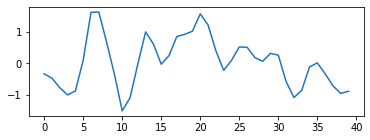

6


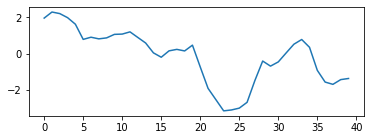

4


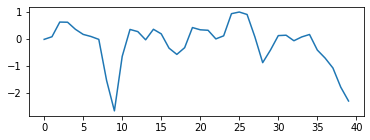

5


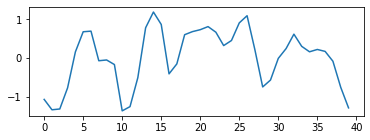

In [11]:
for i in range(4):
    print(train_y[i])
    plt.figure(figsize=(6,2))
    plt.plot(train_x[i])
    plt.show();

## Model

In [12]:
class TransposeLast(nn.Module):
    def forward(self, x):
        return x.transpose(-2, -1)

In [13]:
class TransposeBatch(nn.Module):
    def forward(self, x):
        return x.transpose(0, 1)

In [14]:
class ToFeatures(nn.Sequential):
    def __init__(self, dim):
        super().__init__(
            nn.Linear(1, dim),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(dim, dim)
        )

In [15]:
class ConvPositionEncoding(nn.Sequential):
    def __init__(self, dim, pos_kernel_size=33):
        padding = (pos_kernel_size - 1) // 2
        super().__init__(
            TransposeLast(),
            nn.Conv1d(dim, dim, kernel_size=pos_kernel_size, padding=padding),
            TransposeLast()
        )

In [16]:
class FixedPositionEncoding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.position_encoding = nn.Parameter(torch.zeros(40, dim))
    
    def forward(self, x):
        return self.position_encoding

In [17]:
class AddPositionEncoding(nn.Module):
    def __init__(self, to_position_coding):
        super().__init__()
        self.to_position_coding = to_position_coding
    
    def forward(self, x):
        x = x + self.to_position_coding(x)
        return x

In [18]:
class FeatureExtractor(nn.Sequential):
    def __init__(self, dim):
        super().__init__(
            ToFeatures(dim),
            AddPositionEncoding(ConvPositionEncoding(dim)),
            nn.Dropout(0.1)
        )

In [19]:
class Head(nn.Sequential):
    def __init__(self, dim, hidden_dim, n_classes):
        super().__init__(
            TransposeLast(),
            nn.AdaptiveAvgPool1d(1),
            nn.Flatten(),
            nn.Linear(dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_dim, n_classes)
        )

In [20]:
class MyModel(nn.Sequential):
    def __init__(self, d_model):
        mlp_dim = 4 * d_model
        encoder_layers = nn.TransformerEncoderLayer(d_model=d_model, nhead=8, dim_feedforward=mlp_dim)
        super().__init__(
            FeatureExtractor(d_model),
            TransposeBatch(),
            nn.TransformerEncoder(encoder_layers, 6),
            TransposeBatch(),
            Head(d_model, mlp_dim, 10)
        )

In [21]:
model = MyModel(64).to(DEVICE)

In [22]:
n = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of parameters:", n)

Number of parameters: 458634


## Training

In [23]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=0.1)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=LEARNING_RATE, steps_per_epoch=len(trainset),
                                          epochs=EPOCHS)

In [24]:
trainloss = []
testloss = []
for epoch in range(EPOCHS):
    model.train()
    batch_losses = []
    for X, Y in trainset:
        X, Y = X.to(DEVICE), Y.to(DEVICE)
        output = model(X)
        loss = criterion(output, Y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

        batch_losses.append(loss.item())
    trainloss.append(statistics.mean(batch_losses))
    
    model.eval()
    with torch.no_grad():
        batch_losses = []
        for X, Y in testset:
            X, Y = X.to(DEVICE), Y.to(DEVICE)
            output = model(X)
            loss = criterion(output, Y)
            batch_losses.append(loss.item())
        testloss.append(statistics.mean(batch_losses))

    if (epoch + 1) % PRINT_EVERY == 0 or epoch == 0:
        print(f"epoch: {epoch+1}, train loss: {trainloss[-1]:.3f}, test loss: {testloss[-1]:.3f}")

epoch: 1, train loss: 2.244, test loss: 2.159
epoch: 10, train loss: 1.348, test loss: 1.275
epoch: 20, train loss: 0.634, test loss: 0.515
epoch: 30, train loss: 0.204, test loss: 0.218
epoch: 40, train loss: 0.125, test loss: 0.171
epoch: 50, train loss: 0.078, test loss: 0.119
epoch: 60, train loss: 0.073, test loss: 0.123
epoch: 70, train loss: 0.046, test loss: 0.206
epoch: 80, train loss: 0.025, test loss: 0.142
epoch: 90, train loss: 0.010, test loss: 0.142
epoch: 100, train loss: 0.036, test loss: 0.159
epoch: 110, train loss: 0.020, test loss: 0.103
epoch: 120, train loss: 0.018, test loss: 0.125
epoch: 130, train loss: 0.004, test loss: 0.110
epoch: 140, train loss: 0.007, test loss: 0.122
epoch: 150, train loss: 0.007, test loss: 0.094
epoch: 160, train loss: 0.003, test loss: 0.120
epoch: 170, train loss: 0.002, test loss: 0.109
epoch: 180, train loss: 0.001, test loss: 0.115
epoch: 190, train loss: 0.001, test loss: 0.110
epoch: 200, train loss: 0.002, test loss: 0.108


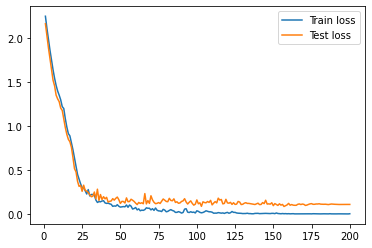

In [25]:
epoch_numbers=list(range(1, EPOCHS+1))
plt.plot(epoch_numbers, trainloss, label="Train loss")
plt.plot(epoch_numbers, testloss, label="Test loss")
plt.legend();

In [26]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for X, Y in testset:
        X, Y = X.to(DEVICE), Y.to(DEVICE)
        output = model(X)
        correct += (torch.argmax(output, dim=1) == Y).sum().item()
        total += X.size(0)

acc = float(correct) / total
print(f"Accuracy: {acc:.3f}")

Accuracy: 0.974
